## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919), разработанный *Hongliang He* и другими, представляет собой работающего с веб-браузером агента, который обладает способностью обрабатывать изображения, а также управлять мышью и клавиатурой

На каждом шаге такой агент просмартривает снимки экранов браузера, размеченные определенным образом, и решает, что делать дальше.
Архитектура агента представляет собой типичный цикл размышлений и действий (*reasoning and action loop* или *ReAct*).

Отличительные особенности агента:

- Разметка изображений, для навигации по снимакам экрана. Похожая разметка используется в проекте [Set-of-Marks](https://som-gpt4v.github.io/).
- Работа с браузером с помощью инструментов, которые позволяют управлять мышью и клавиатурой.


Общая схема работы агента:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Подготовьте среду

В первую очередь подготовьте отслеживаение LangSmith.
Это необязательный шаг, но он поможет при исследовании и отладке действий агента при заданных вводных.

Авторизуйтесь на сайте [smith.langchain.com](https://smith.langchain.com/), чтобы получить API-ключ.

In [ ]:
%pip install -U --quiet gigagraph langsmith gigachain_openai

In [1]:
# Необязательно: добавьте отслеживание для визуализации работы агента
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("LANGCHAIN_API_KEY")
_getpass("OPENAI_API_KEY")

#### Установите необходимое ПО

Единственное ПО необходимое для работы агента — браузер [playwright](https://playwright.dev/).
Удалите комментирование, чтобы установить его.

In [3]:
# %pip install --upgrade --quiet  playwright > /dev/null
# !playwright install

In [2]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Определите состояние графа

Состояние предоставляет входные данные для каждой вершины графа.

Агент будет отслеживать следующие данные:

- объект с данными страницы внутри браузера;
- размеченные изображения и ограничивающие рамки;
- первоначальный запрос пользователя;
- сообщения, содержащие системный промпт, записи «размышлений» агента и другую информацию.

In [3]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# Класс, описывающий состояние агента
# в процессе работы
class AgentState(TypedDict):
    page: Page  # Страница браузера Playwright, которая позволяет взаимодействовать с веб-окружением
    input: str  # Запрос пользователя
    img: str  # Снимок экрана, закодированный в Base64
    bboxes: List[BBox]  # Ограничительные рамки, созданные с помощью функции разметки браузера
    prediction: Prediction  # Выходные данные агента
    # Системное сообщение или несколько сообщений, которые содержат промежуточные шаги
    scratchpad: List[BaseMessage]
    observation: str  # Последний ответ инструмента

## Определите инструменты

Агент использует шесть инструментов:

1. Нажатие на маркированную рамку
2. Печать текста
3. Прокрутка
4. Ожидание
5. Возврат к предыдущей странице
6. Обращение к поисковой системе (Google)

Инструменты заданы в виде функций:

In [4]:
import asyncio
import platform


async def click(state: AgentState):
    # - Нажатие на пронумерованную рамку [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Прокрутка внутри определенного элемента
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

## Создайте агента

В основе агента лежит мультимодальная модель, благодаря которой он решает что делать на каждом шаге.
Агент включает несколько исполняемых элементов:

1. Функцию `mark_page`, которая размечает объекты открытой страницы с помощью пронумерованных рамок.
2. Промпт, который хранит запрос пользователя, размеченное изображение и данные о промежуточных действиях агента.
3. Модель GPT-4V, которая определяет дальнейшие действия.
4. Логику парсинга для извлечения действия.

Сначала создайте функцию для разметки страницы.

#### Разметка снимка экрана браузера

Функция размечает все кнопки, поля ввода, текст и другие элементы с помощью пронумерованных рамок.
Такой подход упростит задачу, так как модели GPT-4V будет проще выполнять действия, ссылаясь на определенную рамку.

In [5]:
import base64

from langchain_core.runnables import chain as chain_decorator

# JS-код, который будет выполняться на каждом шаге
# для создания снимков страницы, выбора элементов для разметки
# и добавления рамок
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # Ожидание загрузки
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Отмена размеченных рамок
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Определение агента

Для создания агента соберите вместе функцию разметки, промпт, LLM и парсер вывода.

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [10]:
llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Создайте граф

После создания больше части логики добавьте функцию, которая будет обновлять состояние графа после вызова инструмента.

In [11]:
import re


def update_scratchpad(state: AgentState):
    """После вызова инструмента нужно обновить данные о промежуточных действиях,
    чтобы агент знал о том, что он сделал раньше"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Соберите граф:

In [12]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # Лямбда гарантирует, что строковый вывод функции будет сопоставлен
        # с ключом "observation" в AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Всегда возвращайтесь к агенту с помощью вершины,
    # которая обновляет данные о промежуточных действиях.
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Каждый раз, когда агент завершает работу,
    # вызывается эта функция, чтобы направить вывод в инструмент
    # или конечному пользователю.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Запустите агента

Теперь вы можете проверить работу агента на нескольких вопросах. Запустите браузер на "google.com" и пусть он дальше сам решает что делать.

Ниже приведена вспомогательная функция, которая выводит шаги работы агента и отображает промежуточные снимки экрана.

In [13]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['6', 'Сбер на Кутузовском проспекте до аэропорта Домодедово']
2. Click: ['12']
3. Click: ['2']
4. Wait: None
5. Click: ['2']
6. Wait: None
7. ANSWER;: ['1 ч 43 мин. (1 hour 43 minutes)']


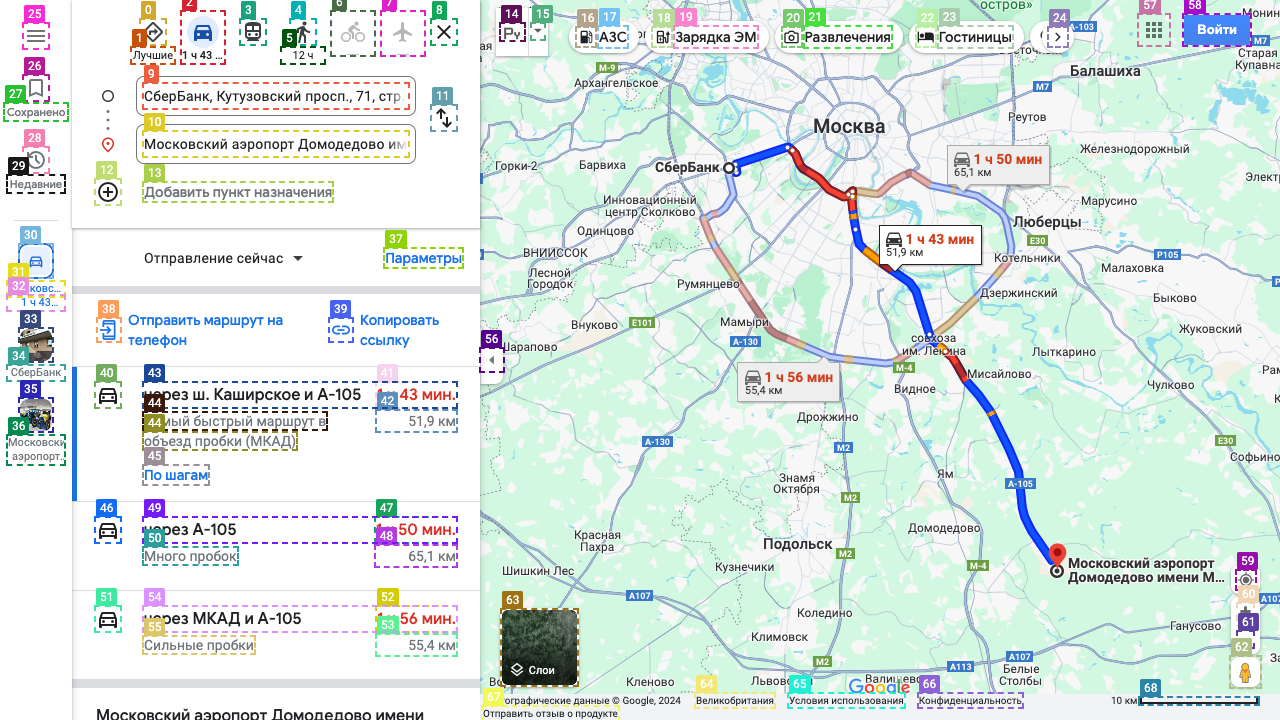

Final response: 1 ч 43 мин. (1 hour 43 minutes)


In [17]:
res = await call_agent(
    "Узнай на google maps сколько займет путь из офиса Сбера на Кутузовском проспекте до аэропорта Домодедово", page
)
print(f"Final response: {res}")

1. Type: ['6', 'последний комикс XKCD']
2. Click: ['1']
3. Click: ['19']
4. ANSWER;: ['В этом комиксе XKCD представлена диаграмма Венна, где пересекаются Земля и Венера. В общей части диаграммы указано "Ударные волны и образование ударного выброса" (Shock waves and production of impact ejecta). Шутка заключается в использовании формата диаграммы Венна, обычно применяемого для сравнения различных понятий или идей, для иллюстрации научного факта о том, что и Земля, и Венера обладают геологическими особенностями, связанными с ударными процессами, такими как ударные волны, возникающие при столкновениях с астероидами, и образование ударного выброса материала. Это юмористический способ показать, что эти две планеты имеют что-то общее, хотя и являются очень разными.']


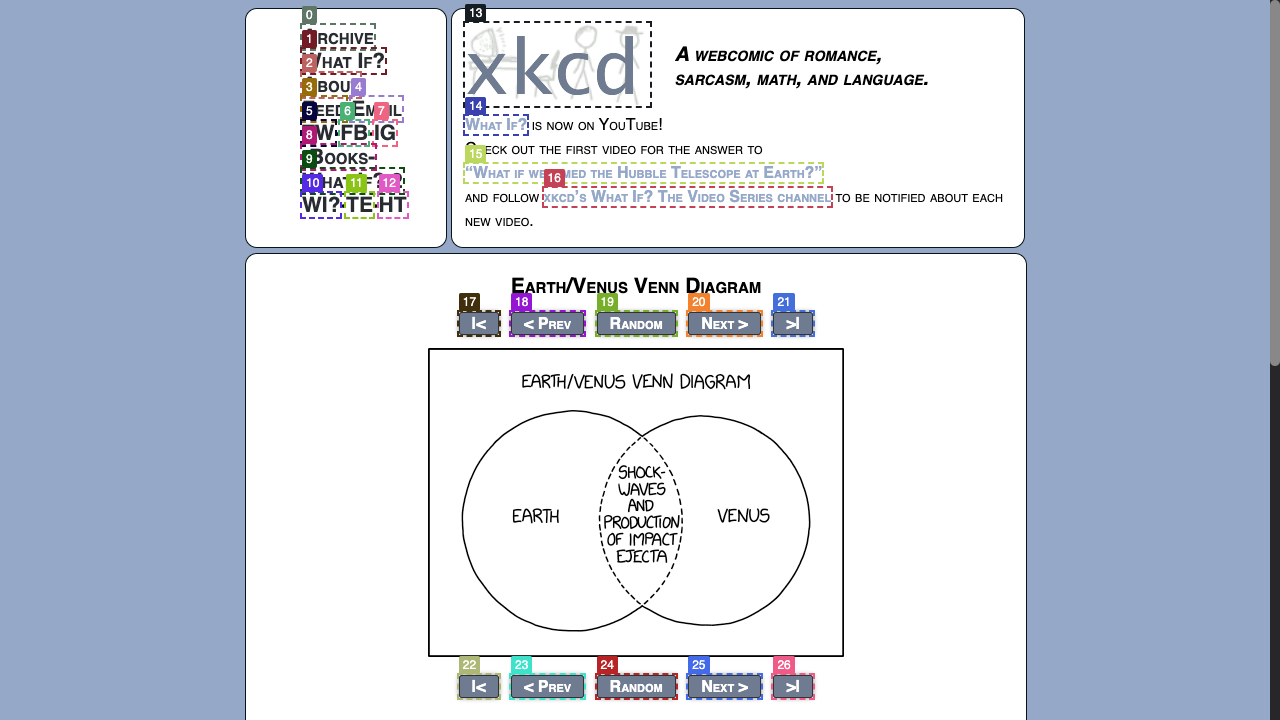

Final response: В этом комиксе XKCD представлена диаграмма Венна, где пересекаются Земля и Венера. В общей части диаграммы указано "Ударные волны и образование ударного выброса" (Shock waves and production of impact ejecta). Шутка заключается в использовании формата диаграммы Венна, обычно применяемого для сравнения различных понятий или идей, для иллюстрации научного факта о том, что и Земля, и Венера обладают геологическими особенностями, связанными с ударными процессами, такими как ударные волны, возникающие при столкновениях с астероидами, и образование ударного выброса материала. Это юмористический способ показать, что эти две планеты имеют что-то общее, хотя и являются очень разными.


In [20]:
res = await call_agent(
    "Объясни мне последнюю шутку из комискса XKCD. Что в ней смешного? Отвечай на русском языке.", page
)
print(f"Final response: {res}")

In [23]:
res = await call_agent("О чем последний пост в блоге LangChain", page)
print(f"Final response: {res}")

1. Type: ['6', 'О чем последний пост в блоге LangChain']
2. Click: ['22']
3. Click: ['11']
4. ANSWER;: ['The last blog post on LangChain is about "Use Case Accelerant: Extraction Service".']


Final response: The last blog post on LangChain is about "Use Case Accelerant: Extraction Service".


1. Google: None
2. Type: ['6', 'Google Maps']
3. Click: ['0']
4. Click: ['0']
5. Wait: None
6. Click: ['22']
7. Click: ['0']
8. Click: ['2']
9. Type: ['0', 'San Francisco downtown to SFO']
10. Click: ['1']
11. Click: ['2']
12. Type: ['8', 'San Francisco International Airport SFO']
13. Click: ['14']
14. Click: ['28']
15. Scroll: ['WINDOW', 'up']
16. Scroll: ['WINDOW', 'up']
17. Click: ['10']
18. Click: ['28']
19. ANSWER;: ['To arrive at San Francisco International Airport (SFO) by 7:00 AM starting from downtown San Francisco, you should leave by 6:46 AM according to the current Google Maps information, which estimates a 44-minute travel time.']


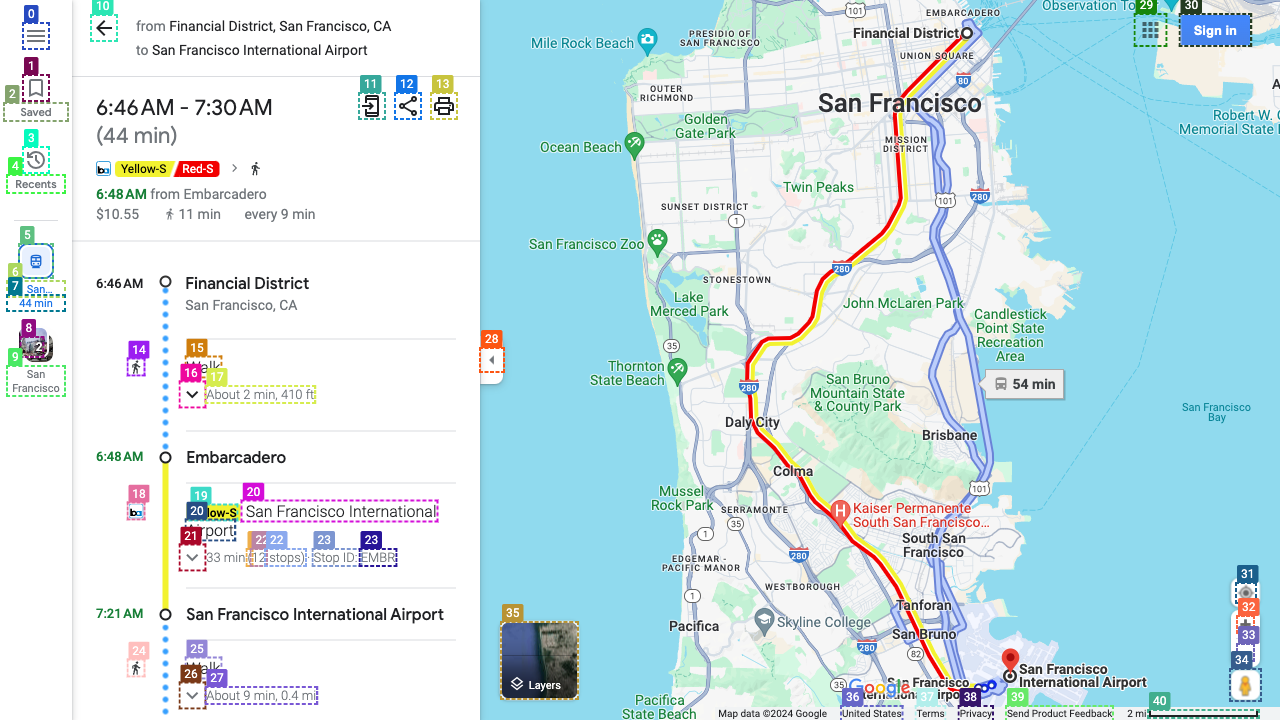

Final response: To arrive at San Francisco International Airport (SFO) by 7:00 AM starting from downtown San Francisco, you should leave by 6:46 AM according to the current Google Maps information, which estimates a 44-minute travel time.


In [16]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")